In [ ]:
# This restacks data after having been scraped from Robospect, such that the 
# final table has rows of spectra, and cols of absorption lines (among other things)

# Created 2021 Feb. 10 by E.S.

In [1]:
import pandas as pd
#from astropy.io import fits
from astropy.io.fits import getdata
import matplotlib.pyplot as plt
import numpy as np

%matplotlib qt

In [5]:
# name of csv file with EWs as produced by pipeline
ew_data_file_name = "/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/ew_products/20210225_restacked_ew_info_good_only.csv"

# read in
df_prestack = pd.read_csv(ew_data_file_name)

In [6]:
# stem of names of FITS files with needed data in header 
fits_stem = "/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/"

In [7]:
# make list of individual spectra for which we have EW data, and
# initialize DataFrame to hold the re-cast data

list_indiv_spectra = list(df_prestack["realization_spec_file_name"].drop_duplicates())

num_indiv_spectra = len(list_indiv_spectra)

df_poststack = pd.DataFrame(columns=["realization_spec_file_name", 
                                     "original_spec_file_name", 
                                     "FeH", "err_FeH", 
                                     "logg", "alpha","Teff",
                                     "EW_Hbeta", "err_EW_Hbeta", 
                                     "EW_Hdelta", "err_EW_Hdelta", 
                                     "EW_Hgamma", "err_EW_Hgamma",
                                     "EW_Heps", "err_EW_Heps",
                                     "EW_CaIIK", "err_EW_CaIIK"], index=range(num_indiv_spectra)) # initialize

for t in range(0,num_indiv_spectra):
    # loop over all spectra realizations we have measured EWs from to populate the dataframe
    
    this_spectrum = list_indiv_spectra[t]
    
    # read in intermediary FITS file to extract values from header
    image, hdr = getdata(fits_stem + this_spectrum.split(".")[0] + ".fits", header=True, ignore_missing_end=True)
    
    logg = hdr["LOGG"]
    teff = hdr["TEFF"]
    alpha = hdr["ALPHA"]
    feh = hdr["FEH"]
    err_feh = 0.15
    
    # select data from table relevant to this spectrum
    data_this_spectrum = df_prestack.where(df_prestack["realization_spec_file_name"] == this_spectrum).dropna().reset_index()
    
    # extract original file name (the one from which realizations are made)
    orig_name = data_this_spectrum["original_spec_file_name"].drop_duplicates().values[0]
    
    # extract Balmer lines from the table of data from all the spectra
    Hbeta = data_this_spectrum["EQW"].where(data_this_spectrum["line_name"] == "Hbet").dropna().values[0]
    err_Hbeta = data_this_spectrum["uncertaintyEQW"].where(data_this_spectrum["line_name"] == "Hbet").dropna().values[0]

    Hgamma = data_this_spectrum["EQW"].where(data_this_spectrum["line_name"] == "Hgam").dropna().values[0]
    err_Hgamma = data_this_spectrum["uncertaintyEQW"].where(data_this_spectrum["line_name"] == "Hgam").dropna().values[0]

    Hdelta = data_this_spectrum["EQW"].where(data_this_spectrum["line_name"] == "Hdel").dropna().values[0]
    err_Hdelta = data_this_spectrum["uncertaintyEQW"].where(data_this_spectrum["line_name"] == "Hdel").dropna().values[0]

    Heps = data_this_spectrum["EQW"].where(data_this_spectrum["line_name"] == "Heps").dropna().values[0]
    err_Heps = data_this_spectrum["uncertaintyEQW"].where(data_this_spectrum["line_name"] == "Heps").dropna().values[0]

    CaIIK = data_this_spectrum["EQW"].where(data_this_spectrum["line_name"] == "CaIIK").dropna().values[0]
    err_CaIIK = data_this_spectrum["uncertaintyEQW"].where(data_this_spectrum["line_name"] == "CaIIK").dropna().values[0]
    
    # fill in that row in the dataframe
    df_poststack.iloc[t]["realization_spec_file_name"] = this_spectrum
    df_poststack.iloc[t]["original_spec_file_name"] = orig_name
    df_poststack.iloc[t]["logg"] = logg
    df_poststack.iloc[t]["Teff"] = teff
    df_poststack.iloc[t]["alpha"] = alpha
    df_poststack.iloc[t]["FeH"] = feh
    df_poststack.iloc[t]["err_FeH"] = err_feh
    df_poststack.iloc[t]["EW_Hbeta"] = Hbeta
    df_poststack.iloc[t]["err_EW_Hbeta"] = err_Hbeta
    df_poststack.iloc[t]["EW_Hdelta"] = Hdelta
    df_poststack.iloc[t]["err_EW_Hdelta"] = err_Hdelta
    df_poststack.iloc[t]["EW_Hgamma"] = Hgamma
    df_poststack.iloc[t]["err_EW_Hgamma"] = err_Hgamma
    df_poststack.iloc[t]["EW_Heps"] = Heps
    df_poststack.iloc[t]["err_EW_Heps"] = err_Heps
    df_poststack.iloc[t]["EW_CaIIK"] = CaIIK
    df_poststack.iloc[t]["err_EW_CaIIK"] = err_CaIIK

KeyError: 'EQW'

In [38]:
# to generate a net Balmer line, make a rescaling of Hgamma
# based on Hdelta

# fit a straight line to Hgam vs Hdel
x_data = df_poststack["EW_Hdelta"].values.astype(float) # Hdel
y_data = df_poststack["EW_Hgamma"].values.astype(float) # Hgam
Hgam = np.copy(y_data)

coeff, cov = np.polyfit(x_data, y_data, 1, full=False, cov=True)
m = coeff[0]
b = coeff[1]
err_m = np.sqrt(np.diag(cov))[0]
err_b = np.sqrt(np.diag(cov))[1]

print("m:")
print(m)
print("b:")
print(b)

# generate a rescaled Hgam, call it rHgam
rHgam = np.divide(np.subtract(Hgam, b), m)

m:
1.0028161410761656
b:
0.405811749477898


In [39]:
## BEGIN TEST TO SEE IF RESCALING IS RIGHT
'''
x_data = df_poststack["EW_Hdelta"].values.astype(float) # Hdel
y_data = rHgam # Hgam
Hgam = np.copy(y_data)

coeff, cov = np.polyfit(x_data, y_data, 1, full=False, cov=True)
m = coeff[0]
b = coeff[1]
err_m = np.sqrt(np.diag(cov))[0]
err_b = np.sqrt(np.diag(cov))[1]

print("m:")
print(m)
print("b:")
print(b)
'''
## END TEST TO SEE IF RESCALING IS RIGHT

m:
1.0
b:
-8.207835965261171e-16


In [40]:
# add column of rescaled Hgamma to DataFrame

df_poststack["EW_resc_Hgamma"] = rHgam

In [8]:
# ... or read in text file of ready-made restacked EW data

df_poststack = pd.read_csv(ew_data_file_name)

In [9]:
# plot: how do Balmer lines scale with each other?

plt.clf()
plt.title("Scaling of lines with Hdelta")
plt.scatter(df_poststack["EW_Hdelta"],df_poststack["EW_Hbeta"], s=3, label="Hbeta")
plt.scatter(df_poststack["EW_Hdelta"],np.add(df_poststack["EW_Hgamma"],4), s=3, label="Hgamma+4")
plt.scatter(df_poststack["EW_Hdelta"],np.add(df_poststack["EW_Heps"],8), s=3, label="Heps+8")
#plt.ylim([0,15])
plt.xlabel("EW, Hdelta (Angstr)")
plt.ylabel("EW, non-Hdelta (Angstr)")
plt.legend()
plt.show()
#plt.savefig("junk_balmer_rescalings.pdf")

In [11]:
# plot: how do Balmer lines scale with Teff?

plt.clf()
plt.title("Scaling of lines with Hdelta")
plt.scatter(df_poststack["Teff"],df_poststack["EW_Hbeta"], s=3, label="Hbeta")
plt.scatter(df_poststack["Teff"],np.add(df_poststack["EW_Hgamma"],6), s=3, label="Hgamma+6")
plt.scatter(df_poststack["Teff"],np.add(df_poststack["EW_Hdelta"],12), s=3, label="Hdel+12")
plt.scatter(df_poststack["Teff"],np.add(df_poststack["EW_Balmer"],18), s=3, label="Net Balmer+18")
plt.scatter(df_poststack["Teff"],np.add(df_poststack["EW_Heps"],24), s=3, label="Heps+24")
#plt.ylim([0,70])
plt.xlabel("Teff (K)")
plt.ylabel("EW (Angstr)")
plt.title("Balmer EW trend with Teff")
plt.legend(ncol=5)
plt.show()
#plt.savefig("junk_balmer_rescalings.pdf")

In [21]:
# find linear trend of net Balmer EW with Teff

# fit a straight line to Hgam vs Hdel
y_data = df_poststack["Teff"].values.astype(float) # Hdel
x_data = df_poststack["EW_Balmer"].values.astype(float) # Hgam

coeff, cov = np.polyfit(x_data, y_data, 1, full=False, cov=True)
m = coeff[0]
b = coeff[1]
err_m = np.sqrt(np.diag(cov))[0]
err_b = np.sqrt(np.diag(cov))[1]

print("m:")
print(m)
print("err_m:")
print(err_m)
print("b:")
print(b)
print("err_b:")
print(err_b)

m:
187.74599028059743
err_m:
3.1053468408029112
b:
5519.840496008796
err_b:
23.64573240449903


In [ ]:
def pred_teff(EW_pass):
    
    teff_pass = np.add(np.multiply(EW_pass,m),b)
    
    return teff_pass

Teff_model = pred_teff(df_poststack["EW_Balmer"])

In [27]:
# make plot of predicted and retrieved Teff

plt.clf()
#plt.scatter(df_poststack["Teff"],np.subtract(Teff_model,df_poststack["Teff"]))
plt.scatter(df_poststack["Teff"],Teff_model)
plt.plot(df_poststack["Teff"],df_poststack["Teff"],"--",color="k")
plt.title("Teff based on Balmer EW")
plt.xlabel("Injected Teff")
plt.ylabel("Retrieved Teff")
plt.show()

In [33]:
# make plot of predicted Teff residuals given Balmer EW

plt.clf()
#plt.scatter(df_poststack["Teff"],np.subtract(Teff_model,df_poststack["Teff"]))
plt.scatter(df_poststack["EW_Balmer"],np.subtract(Teff_model,df_poststack["Teff"]))
#plt.plot(df_poststack["Teff"],np.zeros(len(df_poststack["Teff"])),"--",color="k")
plt.plot(df_poststack["EW_Balmer"],np.zeros(len(df_poststack["Teff"])),"--",color="k")
#plt.title("Teff based on Balmer EW")
plt.title("Teff residuals")
#plt.xlabel("Injected Teff")
plt.xlabel("Balmer EW")
#plt.ylabel("Retrieved Teff")
plt.ylabel("Retrieved Teff")
plt.show()

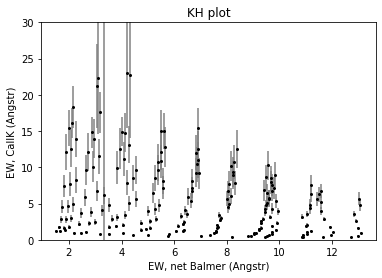

In [77]:
# plot: KH plot

plt.clf()
plt.title("KH plot")
plt.errorbar(df_poststack["EW_resc_Hgamma"],df_poststack["EW_CaIIK"],
             yerr=df_poststack["err_EW_CaIIK"],
             marker="o", markersize=2, mfc="k", mec="k", ecolor="gray", linestyle="")
plt.ylim([0,30])
plt.xlabel("EW, net Balmer (Angstr)")
plt.ylabel("EW, CaIIK (Angstr)")
plt.savefig("junk_KH_plot.pdf")

In [42]:
# write out data

#df_poststack.to_csv("junk_ew_data_20200216.csv")